# Autoformer

In [ ]:
!pip install pandas scikit-learn torchvision numpy matplotlib reformer_pytorch

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Transformer-main/')

In [ ]:
import torch
print(torch.cuda.is_available())         # GPU cihazının kullanılabilir olup olmadığını kontrol et
print(torch.cuda.device_count())         # GPU cihaz sayısını kontrol et
print(torch.cuda.get_device_name())      # Mevcut GPU cihazının adını kontrol et, varsayılan cihaz id'si 0'dan başlar
print(torch.cuda.current_device())       # Mevcut GPU cihaz id'sini kontrol et


True
1
Tesla T4
0


In [ ]:
torch.cuda.is_available()
import torch
torch.cuda.set_device(0)

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Transformer-main/')
import argparse
import torch
from exp.exp_main import Exp_Main #exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false', default=True,
                    help='whether to use distilling in encoder, using this argument means not using distilling')
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# Num_workers, veriyi (batch) yüklemek için kullanılan iş parçacığı (thread) sayısını ifade eder.
parser.add_argument('--itr', type=int, default=2, help='experiments times')#deney sayısı
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience:
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#Otomatik karma hassasiyet ile eğitim kullanma

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = 'Close'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #Çoklu GPU kullanımının belirlenmesi
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = './dataset/crude_oil/'
args.data_path ='crude_oil_data_with_indicators.csv'
args.model_id='Autoformer_96_48_72'
args.model = 'Autoformer'
args.data = 'custom'
args.features = 'MS'
args.seq_len = 96
args.label_len = 48
args.pred_len = 72
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.factor = 3
args.enc_in = 14
args.dec_in =14
args.c_out = 14
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 3
args.distil = True
args.output_attention = False
args.patience= 13
args.learning_rate = 0.0001
args.batch_size = 32
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10
print('Args in experiment:')
print(args)

Exp = Exp_Main

Args in experiment:
{'target': 'Close', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'h', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': './dataset/crude_oil/', 'data_path': 'crude_oil_data_with_indicators.csv', 'model_id': 'Autoformer_96_48_72', 'model': 'Autoformer', 'data': 'custom', 'features': 'MS', 'seq_len': 96, 'label_len': 48, 'pred_len': 72, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 3, 'enc_in': 14, 'dec_in': 14, 'c_out': 14, 'd_model': 512, 'des': 'Exp', 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 13, 'learning_rate': 0.0001, 'batch_size': 32, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 10}


Use GPU: cuda:0
1
>>>>>>>start training : Autoformer_96_48_72_Autoformer_custom_ftMS_sl96_ll48_pl72_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 7524
val 1029
test 2126
	iters: 100, epoch: 1 | loss: 0.1279064
	speed: 0.1531s/iter; left time: 344.5749s
	iters: 200, epoch: 1 | loss: 0.1794918
	speed: 0.1460s/iter; left time: 313.9491s
Epoch: 1 cost time: 35.3799831867218
Epoch: 1, Steps: 235 | Train Loss: 0.2029454 Vali Loss: 0.1715575 Test Loss: 0.2278543
Validation loss decreased (inf --> 0.171557).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1497952
	speed: 0.3909s/iter; left time: 787.9964s
	iters: 200, epoch: 2 | loss: 0.1347942
	speed: 0.1483s/iter; left time: 284.2293s
Epoch: 2 cost time: 35.44503736495972
Epoch: 2, Steps: 235 | Train Loss: 0.1436451 Vali Loss: 0.1735850 Test Loss: 0.1890993
EarlyStopping counter: 1 out of 13
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.0821610
	speed: 0

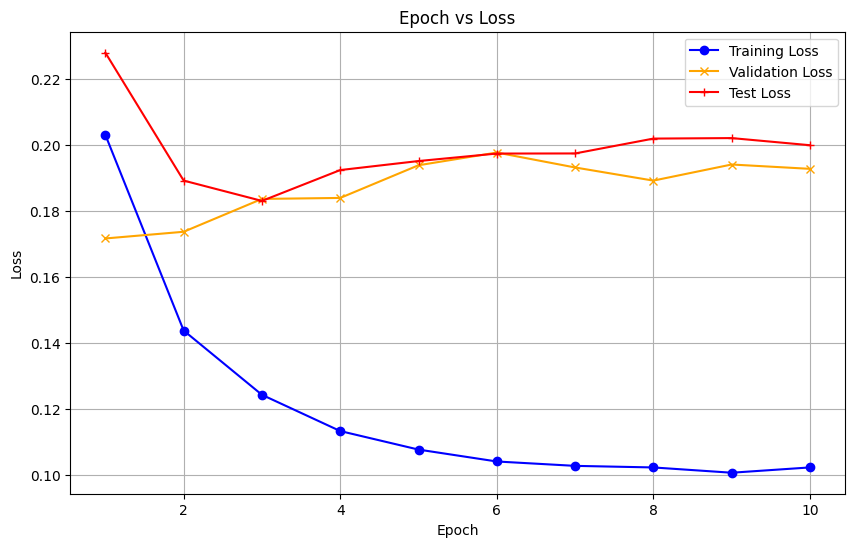

2
>>>>>>>testing : Autoformer_96_48_72_Autoformer_custom_ftMS_sl96_ll48_pl72_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 2126
test shape: (2126, 72, 1) (2126, 72, 1)
test shape: (2126, 72, 1) (2126, 72, 1)
mse:0.2277096062898636, mae:0.3734411895275116, rmse:0.4771892726421356, mape:1.1556822061538696, mspe:172.43841552734375, r2:0.272169291973114
3
Eğitim zamanı: 450.1938 saniye


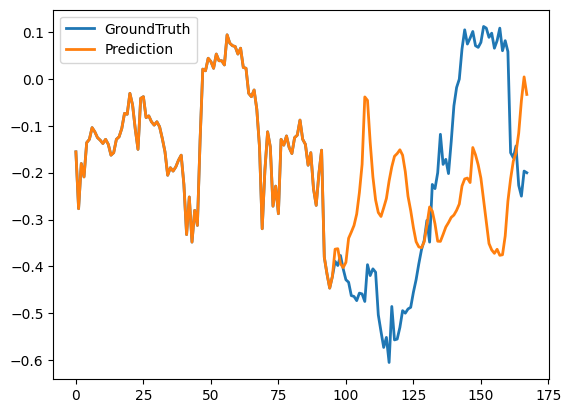

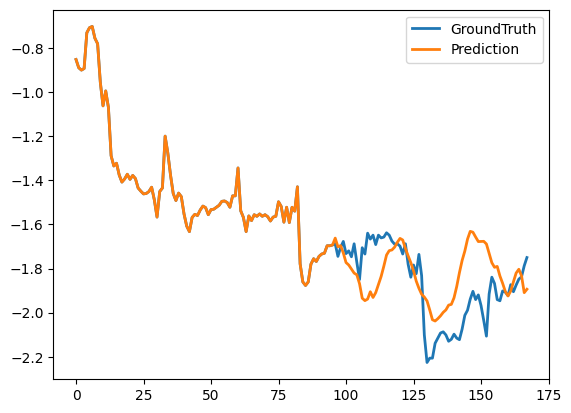

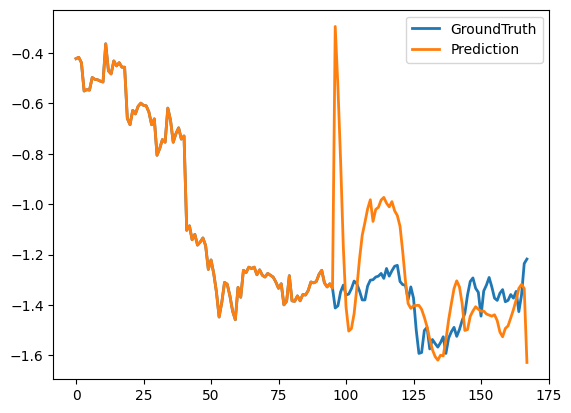

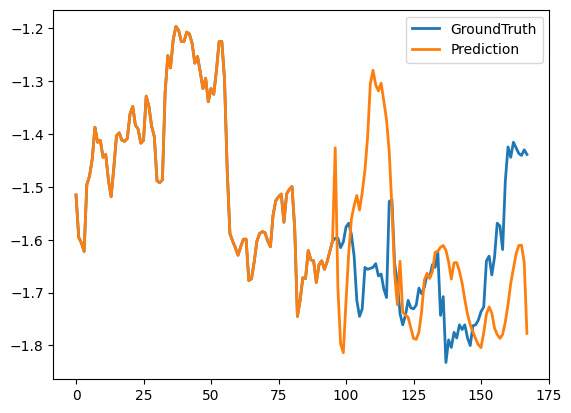

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import time

for ii in range(args.itr):#İtr, epoch değil, deney sayısını ifade eder.
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    # Başlangıç zamanını kaydet
    start_time = time.time()

    exp = Exp(args)  # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # Bitiş zamanını kaydet
    end_time = time.time()
    # Çalışma süresini hesapla
    execution_time = end_time - start_time
    print(f"Eğitim zamanı: {execution_time:.4f} saniye")

    # Başlangıç zamanını kaydet
    start_time_2 = time.time()

    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()

    # Bitiş zamanını kaydet
    end_time_2 = time.time()
    # Çalışma süresini hesapla
    execution_time = end_time_2 - start_time_2
    print(f"Test zamanı: {execution_time:.4f} saniye")

# Informer

In [15]:
!pip install pandas scikit-learn torchvision numpy matplotlib reformer_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-py3-none-any.whl size=2887 sha256=52a51218898c568aec95edbc54fe074c67293813bade47ce5e14aa91f54880d8
  Stored in directory: /root/.cache/pip/wheels/b1/cb/39/7ce7ff2d2fd37cfe1fe7b3a3c43cf410632b2ad3b3f3986d73
Successfully built axial-positional-embedding


In [16]:
import os
os.chdir('/content/drive/MyDrive/Transformer-main/')

In [17]:
import torch
print(torch.cuda.is_available())         # GPU cihazının kullanılabilir olup olmadığını kontrol et
print(torch.cuda.device_count())         # GPU cihaz sayısını kontrol et
print(torch.cuda.get_device_name())      # Mevcut GPU cihazının adını kontrol et, varsayılan cihaz id'si 0'dan başlar
print(torch.cuda.current_device())       # Mevcut GPU cihaz id'sini kontrol et

True
1
Tesla T4
0


In [18]:
torch.cuda.is_available()
import torch
torch.cuda.set_device(0)

In [19]:
import os
os.chdir('/content/drive/MyDrive/Transformer-main/')
import argparse
import torch
from exp.exp_main import Exp_Main #exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false', default=True,
                    help='whether to use distilling in encoder, using this argument means not using distilling')
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# Num_workers, veriyi (batch) yüklemek için kullanılan iş parçacığı (thread) sayısını ifade eder.
parser.add_argument('--itr', type=int, default=2, help='experiments times')#deney sayısı
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience:
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#Otomatik karma hassasiyet ile eğitim kullanma

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = 'Close'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #Çoklu GPU kullanımının belirlenmesi
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = './dataset/crude_oil/'
args.data_path ='crude_oil_data_with_indicators.csv'
args.model_id='Informer_96_48_72'
args.model = 'Informer'
args.data = 'custom'
args.features = 'MS'
args.seq_len = 96
args.label_len = 48
args.pred_len = 72
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.factor = 3
args.enc_in = 14
args.dec_in =14
args.c_out = 14
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 3
args.distil = True
args.output_attention = False
args.patience= 13
args.learning_rate = 0.0001
args.batch_size = 32
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10
print('Args in experiment:')
print(args)

Exp = Exp_Main

Args in experiment:
{'target': 'Close', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'h', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': './dataset/crude_oil/', 'data_path': 'crude_oil_data_with_indicators.csv', 'model_id': 'Informer_96_48_72', 'model': 'Informer', 'data': 'custom', 'features': 'MS', 'seq_len': 96, 'label_len': 48, 'pred_len': 72, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 3, 'enc_in': 14, 'dec_in': 14, 'c_out': 14, 'd_model': 512, 'des': 'Exp', 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 13, 'learning_rate': 0.0001, 'batch_size': 32, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 10}


In [20]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import time

for ii in range(args.itr):#İtr, epoch değil, deney sayısını ifade eder.
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    # Başlangıç zamanını kaydet
    start_time = time.time()

    exp = Exp(args)  # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # Bitiş zamanını kaydet
    end_time = time.time()
    # Çalışma süresini hesapla
    execution_time = end_time - start_time
    print(f"Eğitim zamanı: {execution_time:.4f} saniye")

    # Başlangıç zamanını kaydet
    start_time_2 = time.time()

    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()

    # Bitiş zamanını kaydet
    end_time_2 = time.time()
    # Çalışma süresini hesapla
    execution_time = end_time_2 - start_time_2
    print(f"Test zamanı: {execution_time:.4f} saniye")

Use GPU: cuda:0
1
>>>>>>>start training : Informer_96_48_72_Informer_custom_ftMS_sl96_ll48_pl72_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 7524
val 1029
test 2126
	iters: 100, epoch: 1 | loss: 0.1446988
	speed: 0.1195s/iter; left time: 268.9939s
	iters: 200, epoch: 1 | loss: 0.1489151
	speed: 0.0868s/iter; left time: 186.6453s
Epoch: 1 cost time: 23.943017721176147
Epoch: 1, Steps: 235 | Train Loss: 0.1825736 Vali Loss: 0.1092967 Test Loss: 0.1900362
Validation loss decreased (inf --> 0.109297).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1128112
	speed: 0.1787s/iter; left time: 360.3145s
	iters: 200, epoch: 2 | loss: 0.1120849
	speed: 0.0882s/iter; left time: 169.0282s
Epoch: 2 cost time: 22.240209102630615
Epoch: 2, Steps: 235 | Train Loss: 0.1170164 Vali Loss: 0.1344817 Test Loss: 0.1360328
EarlyStopping counter: 1 out of 13
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.0973669
	speed: 0.

# Reformer

In [ ]:
!pip install pandas scikit-learn torchvision numpy matplotlib reformer_pytorch

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Transformer-main/')

In [ ]:
import torch
print(torch.cuda.is_available())         # GPU cihazının kullanılabilir olup olmadığını kontrol et
print(torch.cuda.device_count())         # GPU cihaz sayısını kontrol et
print(torch.cuda.get_device_name())      # Mevcut GPU cihazının adını kontrol et, varsayılan cihaz id'si 0'dan başlar
print(torch.cuda.current_device())       # Mevcut GPU cihaz id'sini kontrol et

True
1
Tesla T4
0


In [ ]:
torch.cuda.is_available()
import torch
torch.cuda.set_device(0)

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Transformer-main/')
import argparse
import torch
from exp.exp_main import Exp_Main #exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false', default=True,
                    help='whether to use distilling in encoder, using this argument means not using distilling')
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# Num_workers, veriyi (batch) yüklemek için kullanılan iş parçacığı (thread) sayısını ifade eder.
parser.add_argument('--itr', type=int, default=2, help='experiments times')#deney sayısı
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience:
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#Otomatik karma hassasiyet ile eğitim kullanma

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = 'Close'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #Çoklu GPU kullanımının belirlenmesi
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = './dataset/crude_oil/'
args.data_path ='crude_oil_data_with_indicators.csv'
args.model_id='Reformer_96_48_96'
args.model = 'Reformer'
args.data = 'custom'
args.features = 'MS'
args.seq_len = 96
args.label_len = 48
args.pred_len = 96
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.factor = 3
args.enc_in = 14
args.dec_in =14
args.c_out = 14
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 3
args.distil = True
args.output_attention = False
args.patience= 13
args.learning_rate = 0.0001
args.batch_size = 32
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10
print('Args in experiment:')
print(args)

Exp = Exp_Main

Args in experiment:
{'target': 'Close', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'h', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': './dataset/crude_oil/', 'data_path': 'crude_oil_data_with_indicators.csv', 'model_id': 'Reformer_96_48_96', 'model': 'Reformer', 'data': 'custom', 'features': 'MS', 'seq_len': 96, 'label_len': 48, 'pred_len': 96, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 3, 'enc_in': 14, 'dec_in': 14, 'c_out': 14, 'd_model': 512, 'des': 'Exp', 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 13, 'learning_rate': 0.0001, 'batch_size': 32, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 10}


Use GPU: cuda:0
1
>>>>>>>start training : Reformer_96_48_96_Reformer_custom_ftMS_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 7500
val 1005
test 2102
	iters: 100, epoch: 1 | loss: 0.2489982
	speed: 0.1432s/iter; left time: 320.8170s
	iters: 200, epoch: 1 | loss: 0.3356042
	speed: 0.1411s/iter; left time: 302.1522s
Epoch: 1 cost time: 33.455862283706665
Epoch: 1, Steps: 234 | Train Loss: 0.2712133 Vali Loss: 0.1782873 Test Loss: 0.3810883
Validation loss decreased (inf --> 0.178287).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1732944
	speed: 0.2540s/iter; left time: 509.7814s
	iters: 200, epoch: 2 | loss: 0.2576064
	speed: 0.1373s/iter; left time: 261.7478s
Epoch: 2 cost time: 32.869412422180176
Epoch: 2, Steps: 234 | Train Loss: 0.1875375 Vali Loss: 0.1480488 Test Loss: 0.4248228
Validation loss decreased (0.178287 --> 0.148049).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epo

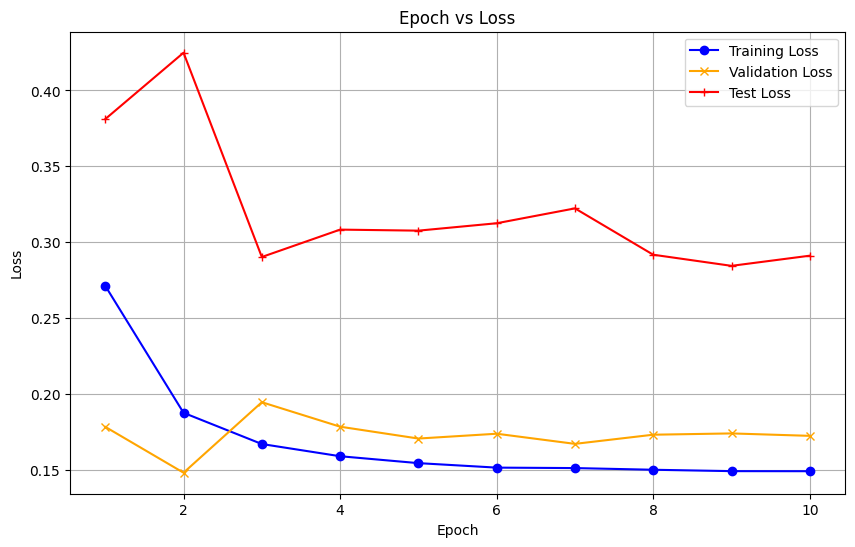

2
>>>>>>>testing : Reformer_96_48_96_Reformer_custom_ftMS_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 2102
test shape: (2102, 96, 1) (2102, 96, 1)
test shape: (2102, 96, 1) (2102, 96, 1)
mse:0.43729057908058167, mae:0.5739702582359314, rmse:0.6612794995307922, mape:1.0970736742019653, mspe:157.36178588867188, r2:-0.4099503755569458
3
Eğitim zamanı: 394.2926 saniye


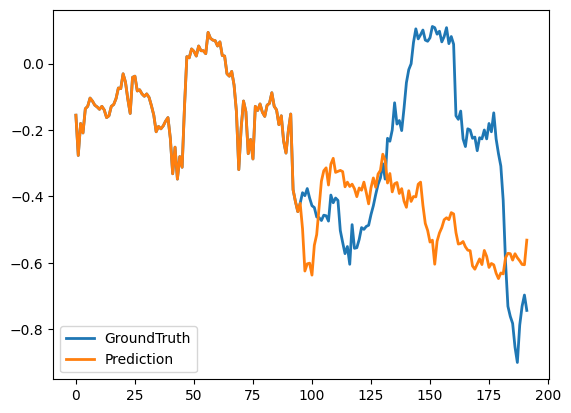

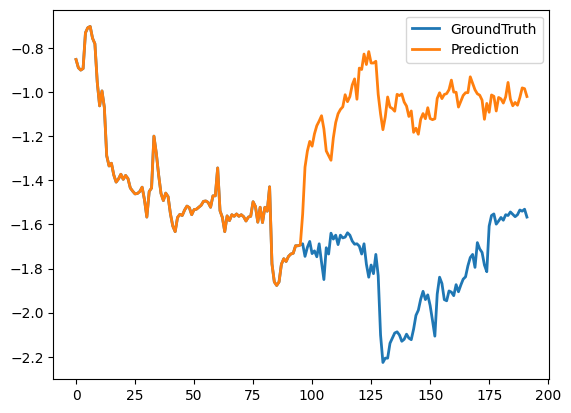

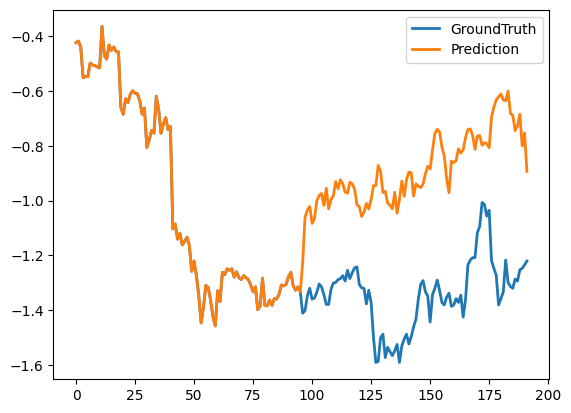

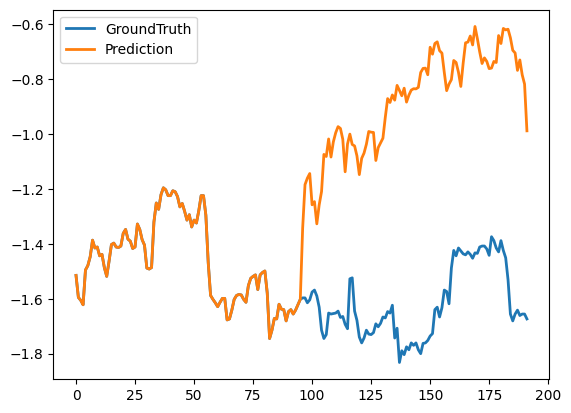

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import time

for ii in range(args.itr):#İtr, epoch değil, deney sayısını ifade eder.
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    # Başlangıç zamanını kaydet
    start_time = time.time()

    exp = Exp(args)  # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # Bitiş zamanını kaydet
    end_time = time.time()
    # Çalışma süresini hesapla
    execution_time = end_time - start_time
    print(f"Eğitim zamanı: {execution_time:.4f} saniye")

    # Başlangıç zamanını kaydet
    start_time_2 = time.time()

    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()

    # Bitiş zamanını kaydet
    end_time_2 = time.time()
    # Çalışma süresini hesapla
    execution_time = end_time_2 - start_time_2
    print(f"Test zamanı: {execution_time:.4f} saniye")

# Vanilla Transformer

In [ ]:
!pip install pandas scikit-learn torchvision numpy matplotlib reformer_pytorch

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Transformer-main/')

In [ ]:
import torch
print(torch.cuda.is_available())         # GPU cihazının kullanılabilir olup olmadığını kontrol et
print(torch.cuda.device_count())         # GPU cihaz sayısını kontrol et
print(torch.cuda.get_device_name())      # Mevcut GPU cihazının adını kontrol et, varsayılan cihaz id'si 0'dan başlar
print(torch.cuda.current_device())       # Mevcut GPU cihaz id'sini kontrol et


True
1
Tesla T4
0


In [ ]:
torch.cuda.is_available()
import torch
torch.cuda.set_device(0)

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Transformer-main/')
import argparse
import torch
from exp.exp_main import Exp_Main #exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict

fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')#Reformer
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')#Reformer
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false', default=True,
                    help='whether to use distilling in encoder, using this argument means not using distilling')
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# Num_workers, veriyi (batch) yüklemek için kullanılan iş parçacığı (thread) sayısını ifade eder.
parser.add_argument('--itr', type=int, default=2, help='experiments times')#deney sayısı
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')#就是epoch
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')#patience:
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)#Otomatik karma hassasiyet ile eğitim kullanma

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
args.target = 'Close'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: #Çoklu GPU kullanımının belirlenmesi
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
args.freq = 'h'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = './dataset/crude_oil/'
args.data_path ='crude_oil_data_with_indicators.csv'
args.model_id='Transformer_96_48_96'
args.model = 'Transformer'
args.data = 'custom'
args.features = 'MS'
args.seq_len = 96
args.label_len = 48
args.pred_len = 96
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.factor = 3
args.enc_in = 14
args.dec_in =14
args.c_out = 14
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 3
args.distil = True
args.output_attention = False
args.patience= 13
args.learning_rate = 0.0001
args.batch_size = 32
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10
print('Args in experiment:')
print(args)

Exp = Exp_Main

Args in experiment:
{'target': 'Close', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': True, 'use_multi_gpu': False, 'freq': 'h', 'checkpoints': './checkpoints/', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'root_path': './dataset/crude_oil/', 'data_path': 'crude_oil_data_with_indicators.csv', 'model_id': 'Transformer_96_48_96', 'model': 'Transformer', 'data': 'custom', 'features': 'MS', 'seq_len': 96, 'label_len': 48, 'pred_len': 96, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'factor': 3, 'enc_in': 14, 'dec_in': 14, 'c_out': 14, 'd_model': 512, 'des': 'Exp', 'itr': 1, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 13, 'learning_rate': 0.0001, 'batch_size': 32, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse', 'train_epochs': 10}


Use GPU: cuda:0
1
>>>>>>>start training : Transformer_96_48_96_Transformer_custom_ftMS_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 7500
val 1005
test 2102
	iters: 100, epoch: 1 | loss: 0.1768160
	speed: 0.1010s/iter; left time: 226.4124s
	iters: 200, epoch: 1 | loss: 0.1349652
	speed: 0.0964s/iter; left time: 206.3113s
Epoch: 1 cost time: 23.402089834213257
Epoch: 1, Steps: 234 | Train Loss: 0.1903709 Vali Loss: 0.1287894 Test Loss: 0.1439707
Validation loss decreased (inf --> 0.128789).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1195875
	speed: 0.1893s/iter; left time: 379.9718s
	iters: 200, epoch: 2 | loss: 0.0862786
	speed: 0.0970s/iter; left time: 184.9514s
Epoch: 2 cost time: 23.556772232055664
Epoch: 2, Steps: 234 | Train Loss: 0.1069221 Vali Loss: 0.1805210 Test Loss: 0.1699368
EarlyStopping counter: 1 out of 13
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.0492619
	spe

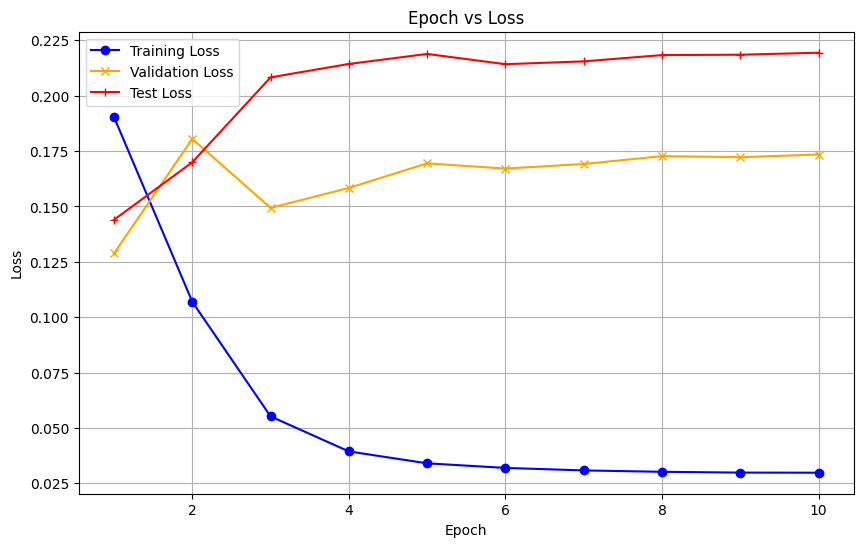

2
>>>>>>>testing : Transformer_96_48_96_Transformer_custom_ftMS_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 2102
test shape: (2102, 96, 1) (2102, 96, 1)
test shape: (2102, 96, 1) (2102, 96, 1)
mse:0.1445561796426773, mae:0.2929163873195648, rmse:0.3802054524421692, mape:1.04844331741333, mspe:228.11842346191406, r2:0.533909410238266
3
Eğitim zamanı: 283.8667 saniye


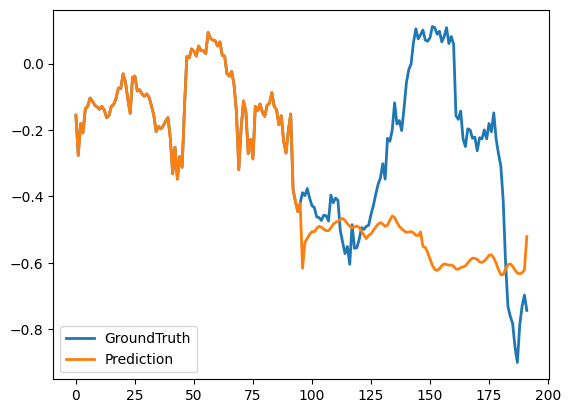

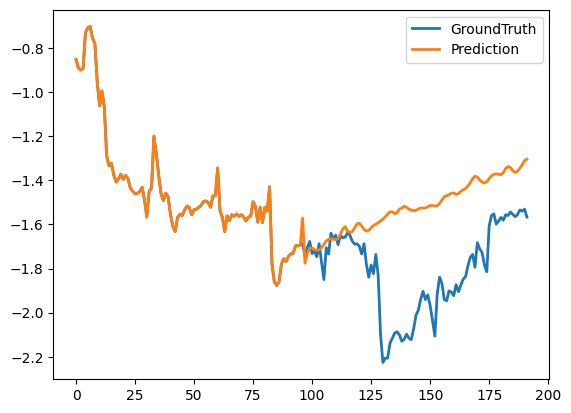

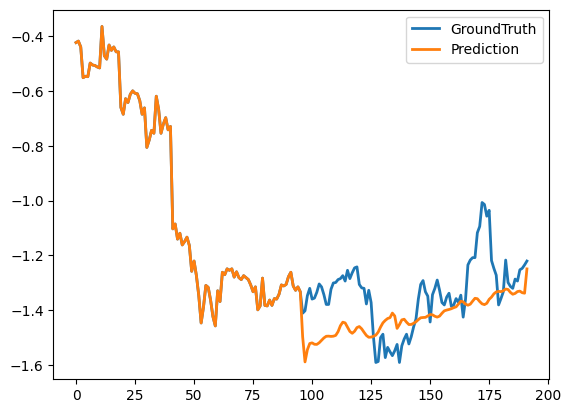

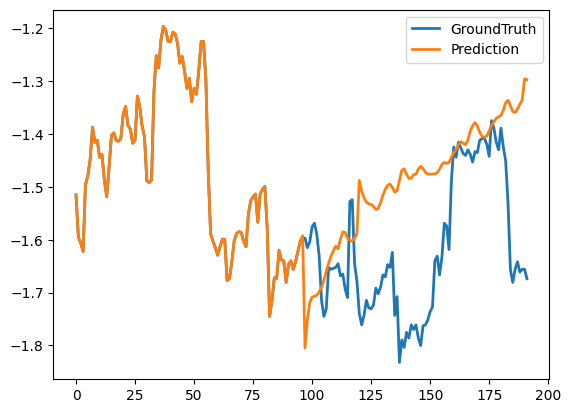

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import time

for ii in range(args.itr):#İtr, epoch değil, deney sayısını ifade eder.
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    # Başlangıç zamanını kaydet
    start_time = time.time()

    exp = Exp(args)  # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # Bitiş zamanını kaydet
    end_time = time.time()
    # Çalışma süresini hesapla
    execution_time = end_time - start_time
    print(f"Eğitim zamanı: {execution_time:.4f} saniye")

    # Başlangıç zamanını kaydet
    start_time_2 = time.time()

    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()

    # Bitiş zamanını kaydet
    end_time_2 = time.time()
    # Çalışma süresini hesapla
    execution_time = end_time_2 - start_time_2
    print(f"Test zamanı: {execution_time:.4f} saniye")

# ETT

In [1]:
# PyTorch ve diğer kütüphaneleri yükle
!pip install torch
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
os.chdir('/content/drive/MyDrive/')
import pandas as pd

data_path = '/content/drive/MyDrive/Transformer-main/dataset/crude_oil/crude_oil_data_with_indicators.csv'

data = pd.read_csv(data_path)


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os

# 1. Sadece sayısal verileri seç
numeric_data = data.select_dtypes(include=[np.number])

# 2. MinMaxScaler ile sayısal veriyi ölçeklendir
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(numeric_data)

# 3. Ölçeklendirilmiş veriyi DataFrame'e çevir
scaled_data = pd.DataFrame(data_scaled, columns=numeric_data.columns, index=data.index)

# 4. Tarih verisini tekrar ekle
scaled_data['date'] = data['date']

In [3]:
# Saatlik verileri eğitim ve test setlerine ayıralım
train_size = int(len(scaled_data) * 0.8)  # Veri setinin %80'ini eğitim için
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [4]:
# Öznitelikler (X) ve etiket (y) oluşturma
def create_dataset(data, time_step=5):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        # Geçmiş `time_step` saatlik veriyi özellik olarak alıyoruz
        X.append(data.iloc[i:(i + time_step)].drop(columns=['date']).values)
        # Gelecekteki 1. saatin 'Close' fiyatını etiket olarak alıyoruz
        y.append(data.iloc[i + time_step]['Close'])
    return np.array(X), np.array(y)

# Eğitim ve test setleri için X ve y oluşturma
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [5]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TransformerModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Transformer Encoder layer
        self.transformer = nn.Transformer(input_dim=input_size, num_heads=8, num_layers=num_layers)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Transformer model apply
        transformer_out = self.transformer(x)

        # Output layer
        out = self.fc(transformer_out[:, -1, :])  # Son zaman dilimi çıktısı
        return out

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 10/100, Train Loss: 0.03473256155848503, Test Loss: 0.0769234225153923
Epoch 20/100, Train Loss: 0.02442680113017559, Test Loss: 0.03962748125195503
Epoch 30/100, Train Loss: 0.018181493505835533, Test Loss: 0.020372046157717705
Epoch 40/100, Train Loss: 0.01425093598663807, Test Loss: 0.015001100488007069
Epoch 50/100, Train Loss: 0.013476586900651455, Test Loss: 0.009309746325016022
Epoch 60/100, Train Loss: 0.012006495147943497, Test Loss: 0.008244768716394901
Epoch 70/100, Train Loss: 0.010286557488143444, Test Loss: 0.007874852977693081
Epoch 80/100, Train Loss: 0.008049968630075455, Test Loss: 0.00509170675650239
Epoch 90/100, Train Loss: 0.006315195932984352, Test Loss: 0.003259567078202963
Epoch 100/100, Train Loss: 0.005555253010243177, Test Loss: 0.0031623924151062965
Eğitim ve Test zamanı: 570.9264 saniye


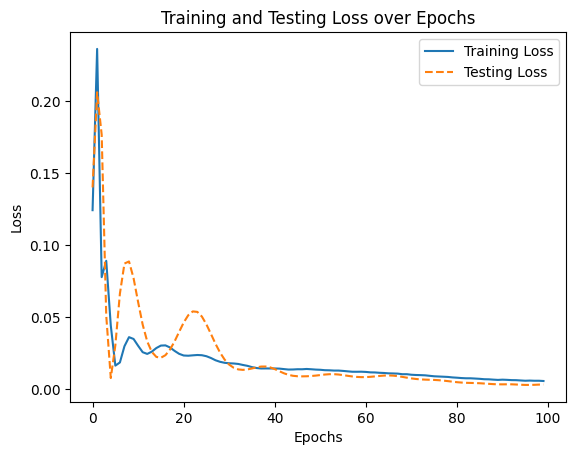

In [12]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import time

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TransformerModel, self).__init__()


        # nhead parametresi input_size ile uyumlu olmalı
        nhead = input_size // 2  # Örneğin, input_size'ın yarısı kadar başlık kullanabiliriz
        if input_size % nhead != 0:
            nhead = 4  # Fallback bir değer

        # Encoder için Transformer yapısını oluşturuyoruz
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # Tam bağlantılı katman (fully connected layer)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Transformer'a uygun şekilde boyutları düzenliyoruz
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, input_size) -> (seq_len, batch_size, input_size)

        # Transformer'dan geçiş
        x = self.transformer_encoder(x)

        # Çıkışı son katmandan geçirme
        x = x.mean(dim=0)  # Zaman boyutunu (seq_len) ortalıyoruz
        x = self.fc(x)
        return x

# Eğitim ve test kayıplarını saklamak
train_losses = []
test_losses = []

# Model parametreleri
input_size = X_train.shape[2]  # Özellik sayısı (örneğin, 14)
hidden_size = 64  # Gizli katman boyutu
num_layers = 2  # Katman sayısı
output_size = 1  # Tek bir çıktı (petrol fiyatı)

# Modeli başlatma
model = TransformerModel(input_size, hidden_size, num_layers, output_size)

# Kayıp fonksiyonu ve optimizasyon
criterion = nn.MSELoss()  # Kayıp fonksiyonu (MSE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Başlangıç zamanını kaydet
start_time = time.time()

# Eğitim döngüsü
num_epochs = 100
for epoch in range(num_epochs):
    # Eğitim modu
    model.train()
    train_inputs = torch.tensor(X_train, dtype=torch.float32)
    train_labels = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    # İleri besleme ve kayıp hesaplama
    train_outputs = model(train_inputs)
    train_loss = criterion(train_outputs, train_labels)

    # Geriye yayılım (backpropagation)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Eğitim kaybını sakla
    train_losses.append(train_loss.item())

    # Test kaybı hesaplama
    model.eval()
    with torch.no_grad():
        test_inputs = torch.tensor(X_test, dtype=torch.float32)
        test_labels = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        test_losses.append(test_loss.item())

    # Her 10 epoch'ta bir kayıpları yazdır
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}")

# Bitiş zamanını kaydet
end_time = time.time()

# Çalışma süresini hesapla
execution_time = end_time - start_time
print(f"Eğitim ve Test zamanı: {execution_time:.4f} saniye")

# Eğitim ve test kayıplarını görselleştir
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

Test Loss: 0.0031623924151062965


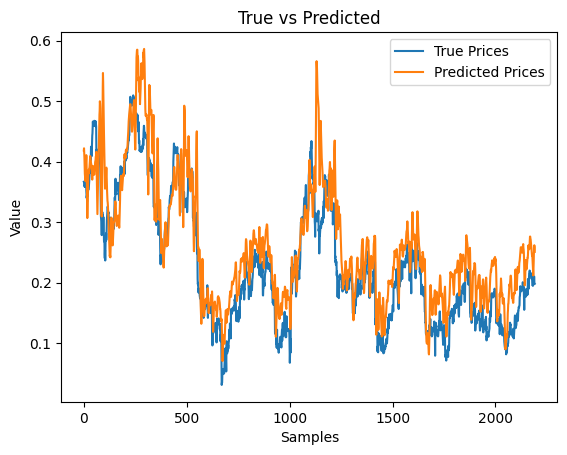

In [13]:
# Test veri seti ile tahmin yapma
model.eval()  # Değerlendirme moduna alma
inputs_test = torch.tensor(X_test, dtype=torch.float32)
labels_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Modelden tahminleri al
outputs_test = model(inputs_test)

# Test kaybını hesapla
test_loss = criterion(outputs_test, labels_test)
print(f"Test Loss: {test_loss.item()}")

# Sonuçları görselleştir
plt.plot(labels_test.numpy(), label="True Prices")
plt.plot(outputs_test.detach().numpy(), label="Predicted Prices")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Value")
plt.title("True vs Predicted")
plt.show()

In [14]:
import numpy as np

# MSE (Mean Squared Error)
mse = np.mean((outputs_test.detach().numpy() - labels_test.numpy())**2)

# MAE (Mean Absolute Error)
mae = np.mean(np.abs(outputs_test.detach().numpy() - labels_test.numpy()))

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Sıfır olan değerleri kontrol et ve çok küçük bir değerle değiştir
epsilon = 1e-10  # Küçük bir değer
y_test_safe = np.where(labels_test.numpy() == 0, epsilon, labels_test.numpy())

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((outputs_test.detach().numpy() - labels_test.numpy()) / y_test_safe)) * 100

# MSPE (Mean Squared Percentage Error)
mspe = np.mean(((outputs_test.detach().numpy() - labels_test.numpy()) / y_test_safe)**2) * 100

# R² (R-squared)
ss_res = np.sum((outputs_test.detach().numpy() - labels_test.numpy())**2)
ss_tot = np.sum((labels_test.numpy() - np.mean(labels_test.numpy()))**2)
r2 = 1 - (ss_res / ss_tot)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"MSPE: {mspe}")
print(f"R²: {r2}")

MSE: 0.0031623924151062965
MAE: 0.045003801584243774
RMSE: 0.05623515322804451
MAPE: 24.86761063337326
MSPE: 11.352845281362534
R²: 0.7117978036403656
